In [1]:
%pylab inline
%matplotlib notebook

rcParams["figure.figsize"] = (16,5)
from IPython.display import Audio
import librosa.display
import pyaudio
import pandas as pd
import numpy as np
import librosa
import pyworld
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.io import wavfile
import math
import random
import struct
import wave



Populating the interactive namespace from numpy and matplotlib


<ipython-input-2-3ea8eb452ed1>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = wavfile.read(filename)


<IPython.core.display.Javascript object>


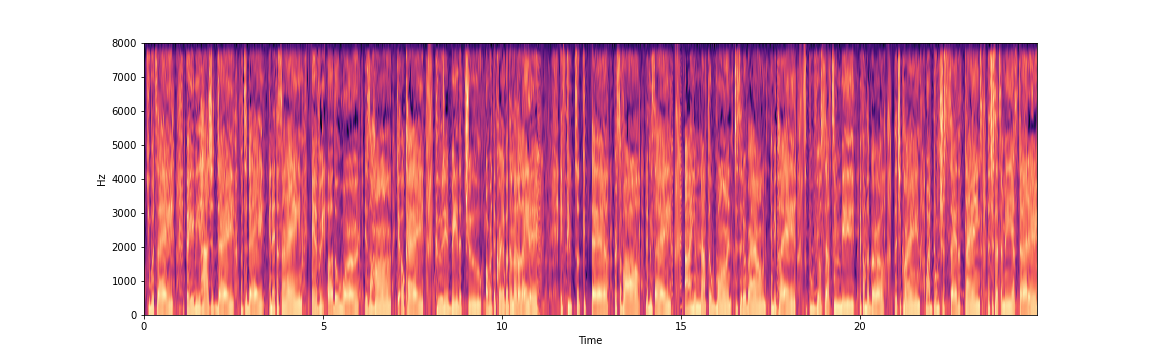

In [2]:
filename = 'beyonce_sample.wav'

# Load wav file
fs, x = wavfile.read(filename)
x = x.astype(np.float64)

# Use its python wrapper pyworld.A high-quality speech analysis, manipulation and synthesis system for acoustic feature extraction purpose.

frame_period = 20 # ms
hop_length = int(0.001 * fs * frame_period)

x = x.astype(np.float64)
f0, timeaxis = pyworld.harvest(x, fs, frame_period=frame_period)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)  #harmonic spectral envelope estimation algorithm
aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)


# spectrogram representaion
librosa.display.specshow(np.log(spectrogram).T, sr=fs,
                         hop_length=hop_length, x_axis="time",
                         y_axis="linear", cmap="magma")


<IPython.core.display.Javascript object>


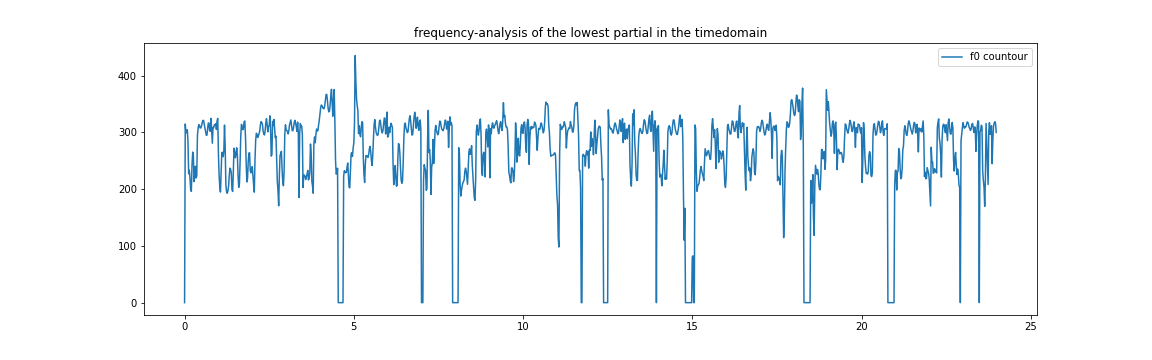

In [3]:
# CUT F0, SPECTROGRAM SHORTER:
make_shorter = int(int(len(f0) * frame_period/1000) * 1000/frame_period)

f0 = f0[:make_shorter] # round f0 to lower secondamount!!. ex. 24.95 = 24 seconds. should work no matter the frameperiod.
timeaxis = timeaxis[:make_shorter]
spectrogram = spectrogram[:make_shorter]

data = f0
df = pd.DataFrame(data,index = timeaxis,columns=['f0 countour'])
  
# Print the data
df.plot(title='frequency-analysis of the lowest partial in the timedomain')

In [4]:
frequency = df.iloc[:,0].to_list()
time_intervals = df.index.to_list()
freq_series = list(zip(time_intervals,frequency))
duration = round(df.index[-1])
samples_per_second = int(len(frequency)/duration)


# 200 samples per second with a framesize of 80 frames per sample. This means one sinewave frequency takes 1/200 of a second
# , which is 0.05 seconds.

In [5]:
# functions for filtering:

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
    
def filter_series(data,lowcut,highcut,fs=fs,n=3):
    for i in range(n):
        data = butter_bandpass_filter(data, lowcut, highcut, fs, order=2)
        
    return data


In [6]:
temp = [x for x in f0 if x!=0]
temp.sort()
lowest_freq = int(temp[0]) # lowest frequency in f0
highest_freq = int(temp[-1]) # highest frequenct in f0.

# get highest and lowest freq per second:

seconds_to_slice_per_freq = 0.5
indice = int(int(1000/frame_period) * seconds_to_slice_per_freq)


low_per_segment = []
high_per_segment = []


for index,num in enumerate(f0):
    if index%indice==0:
        arr = f0[index:(index+indice)]
        arr = arr[arr != 0]
        low = arr.min()
        low_per_segment.append(low)
        high = arr.max()
        high_per_segment.append(high)
        
# give indexes of frames in audiofile where there is silence.
silence_indices = []

for idx,num in enumerate(f0):
    if num == 0:
        silence_indices.append(idx)

# get indexes where distance between silent frames is more than 2. Use these as indexes for trimming later on.     
silence_distance = []

for index, item in enumerate(silence_indices):
    if silence_indices[index] - silence_indices[index-1] > 2:
        silence_distance.append(silence_indices[index])

silence_indices = np.array(silence_indices)

silence_index = silence_indices * hop_length
# add [hop_length] indexnumbers to each startindex
real_silence_index = []

for index in silence_index:
    for num in range(1+index,(hop_length+index+1)):
                     real_silence_index.append(num)

In [7]:
# stack filters in order = 2?? see https://ccrma.stanford.edu/~jos/fp/Series_Second_Order_Sections.html
# crossfades: https://stackoverflow.com/questions/20135362/beginner-python-programming-help-to-crossfade-sounds
# https://stackoverflow.com/questions/3637350/how-to-write-stereo-wav-files-in-python


sine_divider = 0.6
counter = 0
amount_seconds = duration
samples = []
# max_freq = round(df.max()[0])
# min_freq = df['f0 countour'].replace(0, np.nan).dropna().sort_values().quantile(0.05) # drops lowest 5 perc. after dropping zeros.


    
for i in range(amount_seconds): # writes i seconds of audio. Set duration here

    mono_channel = []
    for i in range(fs): # fills whole second with f/s
        frequency_index = i % hop_length # this frequency needs to be the same for [hop_length] iterations
        channel = sine_divider * math.sin(2 * math.pi * round(frequency[counter]) * (i / fs)) # dividing fs 
        if frequency_index == (hop_length-1):
            counter += 1
        mono_channel.append(channel)


    for sample in mono_channel: 
        sample = round(sample * (2 ** 15 - 1)) # fixes amplitude. if this number is divided, amplitude will go down.
        samples.append(sample)

# bandpassfilter per second, dynamicly change lowest and highest frequency per second to filter out noise:
samples_filtered = []
frames_per_segment = int(fs * seconds_to_slice_per_freq)


# filter data per timesegment by frequency
for index,num in enumerate(zip(low_per_segment,high_per_segment)):
    min_freq = num[0]
    max_freq = num[1]


    has_nan = True
    n = 3 # n of times to go through series of 2-pole bandpassfilter.


    while has_nan:
        # check if filtering causes nans to appear. if yes, lower n amount for series by 1 until no nan. 
        # if no, validate data.
        filtered_check = filter_series(samples[index*frames_per_segment:(index+1)*frames_per_segment], min_freq, max_freq,fs=fs,n=n) # filter n amount of times
        array_sum = np.sum(filtered_check)
        array_has_nan = np.isnan(array_sum)

        if array_has_nan:
            n -= 1
            print(f'has nan, filterseries: {n}')

        elif abs(filtered_check).max() > 32768:
            n -= 1
            print(f'max number in data exceeds 32768, artifacts likely to occur, filterseries: {n}')

        else:
            has_nan = False
            filtered = filter_series(samples[index*frames_per_segment:(index+1)*frames_per_segment], min_freq, max_freq,fs=fs,n=n) 
            print(filtered[0],filtered[-1])
            samples_filtered.append(filtered)
            print(f'no nan! filterseries: {n}')
            break
            

# CROSSFADE BETWEEN FREQUENCY-SEGMENTS 
# cut areas where frequency was inserted need a crossfade to avoid clicks:

min_index = []
max_index = []
samples_to_lookback = int(hop_length/4) # samples to look back for highest and lowest point to interpolate for a crossfade.

# get index of max and min values of slices:
# samples_filtered should have 2 dimensions here!!!!! length should me more than 1 !!!
for index,t in enumerate(samples_filtered):
    if index >= 1:
        min_value = t[:samples_to_lookback].min()
        index_position = np.where(t==min_value)[0][0] + (index*frames_per_segment)
        min_index.append(index_position)

    if index < len(samples_filtered[:-1]):
        max_value = t[-samples_to_lookback:].max()
        index_position = np.where(t==max_value)[0][0] + (index*frames_per_segment)
        max_index.append(index_position)
        
# make array 1-dimensonal
samples_filtered = np.array(samples_filtered).flatten() # make array 1-dimensonal
sf_copy = samples_filtered.copy()

# place crossfades in data:
for i in zip(max_index,min_index):

    max_fade_idx = samples_filtered[i[0]] 
    min_fade_idx = samples_filtered[i[1]]
    samplespace = len(samples_filtered[i[0]:i[1]+1])

    fade = np.linspace(max_fade_idx,min_fade_idx,samplespace)
    # insert crossfade in data:
    samples_filtered[i[0]:i[1]+1] = fade
    

lookback = 600
post_fades = samples_filtered[max_index[0]-lookback:min_index[0]+lookback]
pre_fades = sf_copy[max_index[0]-lookback:min_index[0]+lookback]

0.0 8723.651478615564
no nan! filterseries: 3
0.0 101.58657384668709
no nan! filterseries: 3
0.0 19911.798547444567
no nan! filterseries: 3
0.0 19871.039702425853
no nan! filterseries: 3
0.0 -8492.061630312783
no nan! filterseries: 3
0.0 9747.47787407436
no nan! filterseries: 3
0.0 2152.408272681486
no nan! filterseries: 3
0.0 7168.071942345061
no nan! filterseries: 3
0.0 6698.409378848681
no nan! filterseries: 3
0.0 10213.057131583526
no nan! filterseries: 3
0.0 -17056.54368944031
no nan! filterseries: 3
0.0 8700.843436987618
no nan! filterseries: 3
0.0 2674.0594708941953
no nan! filterseries: 3
0.0 -18034.7537947298
no nan! filterseries: 3
0.0 -9443.795629728722
no nan! filterseries: 3
0.0 -55.05656040294157
no nan! filterseries: 3
0.0 -14680.351196534037
no nan! filterseries: 3
0.0 7832.750697909181
no nan! filterseries: 3
0.0 -8046.247592854048
no nan! filterseries: 3
0.0 1956.1372166347492
no nan! filterseries: 3
0.0 3391.8609763139552
no nan! filterseries: 3
0.0 -5296.05498187228

<IPython.core.display.Javascript object>


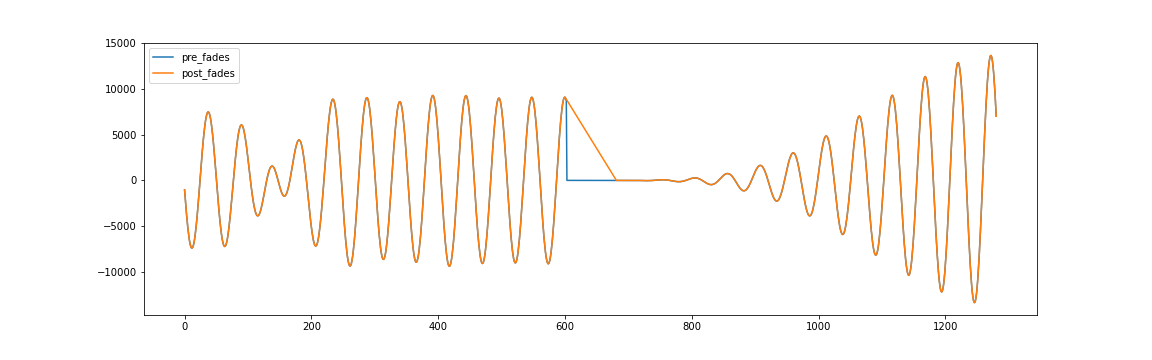

In [8]:
# SEE line pre and post-crossfade, x-axis = frames:

data = {'pre_fades': pre_fades,'post_fades': post_fades}
df2 = pd.DataFrame(data,columns=['pre_fades','post_fades'])

# Print the data
df2.plot()

# use least squares fit to complete with sinewave?? https://stackoverflow.com/questions/48596035/how-can-i-fill-pandas-column-with-a-function-sin-line

In [9]:
# filter second time to cut higher frequency noise. lowest and highest frequency from f0 are being used as cutpoints.
samples_filtered = filter_series(samples_filtered, lowcut=lowest_freq, highcut=highest_freq, fs=fs,n=3)

    
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier


if abs(samples_filtered).max() > 32768:
    amplitude_factor = 32768/abs(samples_filtered).max()
    amplitude_factor = round_down(amplitude_factor,2)

else:
    amplitude_factor = 1

samples_filtered2 = samples_filtered * amplitude_factor


# Create silence in data: set silence indices in array to match original:
for index in real_silence_index:
    samples_filtered2[index] = 0
    
# Adjust velocity per hoplength.

# norm_loudness_freq are the normalised loudness of frequencties from 0 to 1 in a given hoplength. 
# start is lowest frequency, goes higher in increments of 16 hz.
# index most active frequency in norm_loudness_freq. Most relevant frequency area for velocitychanges.  

norm_loudness_freq = np.log(spectrogram)/np.log(spectrogram).max() # normalise frequencies between zero and 1.
idx_act_freq = [round(f0.mean()/16)] # 16 is amount of frequencies per index. Use mean per frequency in hoplength to get most accurate measurement. 

# set velocity indices in array to match velocity-nuances of original:
for index,factor in enumerate(norm_loudness_freq): 
    samples_filtered2[(hop_length*index):hop_length*(index+1)] = factor[idx_act_freq] * samples_filtered2[(hop_length*index):(index+1)*hop_length]
    
    
# filter third time to cut remaining noise.
samples_filtered2 = butter_bandpass_filter(samples_filtered2, lowcut=lowest_freq, highcut=highest_freq, fs=fs, order=2)
samples_filtered_int = np.around(samples_filtered2).astype(int) # cast to int to write to wav


# write to wav:
with wave.open('first_partial_result.wav', "w") as f:
    f.setnchannels(1)
    f.setsampwidth(2) # 2 bytes per sample = total amount of bytes for file: 2*16000*amount_seconds
    f.setframerate(fs)
    
    
    for sample in samples_filtered_int:
        f.writeframes(struct.pack("<h", sample)) # better to write in float and 4 bytes??

max_amplitude = abs(samples_filtered_int).max()
print(f'max amplitude: {max_amplitude}')
print(f'sinedivider: {sine_divider}')
print(f'filterseries: {n}')
print('finished!')

max amplitude: 24223
sinedivider: 0.6
filterseries: 3
finished!
